In [1]:
%reload_ext autoreload
%autoreload 2

import hashlib
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import yaml

from firebase_admin import db
from library.config import get_config_declaration, get_config_options
from library.firebase import initialize_app, get_dataset_ref
from matplotlib.axes import Axes
from os import makedirs
from os.path import exists
from typing import Dict, Tuple

from library.design_space import get_design_space as get_design_space2, get_pareto_front

In [2]:
# MODE = "Detection"
MODE = "Tracking"

ENABLE_TRACKING = MODE == "Tracking"
ENABLE_PERSIST = MODE == "Detection"

VIDEO_FILES = [
    "Baboons/NeilThomas/001",
]

RUNTIME_CONFIG = {
    "display": False,
    "save": True,
    "timings": False,
    "progress": True,
    "enable_tracking": ENABLE_TRACKING,
    "enable_persist": ENABLE_PERSIST
}

initialize_app()

In [3]:
def get_design_space(
    video_file: str, enable_tracking: bool, enable_persist: bool
):
    X, y, current_idx, known_idx = get_design_space2(video_file, enable_tracking, enable_persist)

    with open("./config_declaration.yml", "rb") as f:
        config_hash = hashlib.md5(f.read()).hexdigest()

    sherlock_ref = db.reference("sherlock")

    video_file_ref = get_dataset_ref(video_file, sherlock_ref)
    config_declaration_ref = video_file_ref.child(config_hash)

    if enable_tracking:
        tracking_ref = config_declaration_ref.child("tracking_enabled")
    else:
        tracking_ref = config_declaration_ref.child("tracking_disabled")

    if enable_persist:
        persist_ref = tracking_ref.child("persist_enabled")
    else:
        persist_ref = tracking_ref.child("persist_disabled")

    current_idx = np.array(current_idx)
    current_outputs = np.array(y[current_idx, :])

    known_idx = np.array(known_idx)
    known_outputs = np.array(y[known_idx, :])
        
    ypredict, ypredict_idx, = get_pareto_front(video_file, enable_tracking, enable_persist)

    return y, current_idx, current_outputs, known_outputs, known_idx, ypredict, ypredict_idx, persist_ref

def get_results(
    video_file: str,
    enable_tracking: bool,
    enable_persist: bool,
    ax: Axes,
):
    video_idx = VIDEO_FILES.index(video_file)

    (
        y,
        current_idx,
        current_outputs,
        known_outputs,
        known_idx,
        ypredict,
        ypredict_idx,
        storage_ref,
    ) = get_design_space(video_file, enable_tracking, enable_persist)

    ax.scatter(
        current_outputs[:, 0],
        current_outputs[:, 1],
        c="blue",
        marker="^",
        label="Sampled designs",
    )
    ax.scatter(
        ypredict[:, 0],
        ypredict[:, 1],
        c="red",
        label="Predicted Pareto designs",
    )

    ax.set_title(
        f"Video {video_idx + 1}"
        # + f" with Tracking {'Enabled' if enable_tracking else 'Disabled'}"
        # + f" and Persistence {'Enabled' if enable_persist else 'Disabled'}"
        # + " Design Space"
    )
    ax.set(xlabel="Recall", ylabel="Precision")
    # ax.label_outer()
    # ax.legend()
    # plt.legend(bbox_to_anchor=(1.05, 1.05))
    # plt.xlabel("Recall")
    # plt.ylabel("Precision")
    ax.set_xlim(known_outputs[:, 0].min(), known_outputs[:, 0].max())
    ax.set_ylim(known_outputs[:, 1].min(), known_outputs[:, 1].max())

    # plt.show()

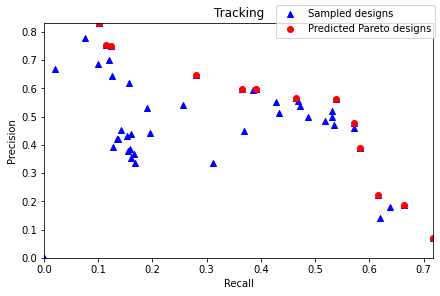

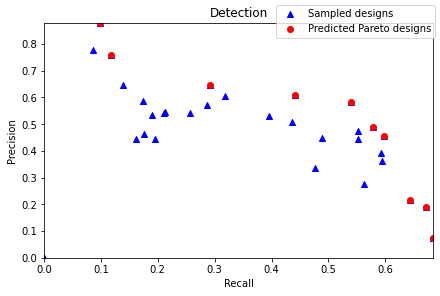

In [10]:
def plot_pareto(enable_tracking: bool, enable_persist: bool):
    for idx, video_file in enumerate(VIDEO_FILES):
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), constrained_layout=True)

        get_results(
            video_file, enable_tracking, enable_persist, axs
        )

        handles, labels = axs.get_legend_handles_labels()
        fig.legend(
            handles, labels
        )

        makedirs("./output/figures", exist_ok=True)
        path = f"./output/figures/fig_baboon_{'tracking' if enable_tracking else 'detection'}_pareto.pdf"
        
        plt.title(f"{'Tracking' if enable_tracking else 'Detection'}")
        plt.savefig(path, format="pdf")

plot_pareto(True, False)
plot_pareto(False, False)

In [5]:
def save_pareto(enable_tracking: bool, enable_persist: bool):
    names = []
    idxes = []
    recalls = []
    precisions = []
    f1s = []

    for i, video_file in enumerate(VIDEO_FILES):
        (
            y,
            current_idx,
            current_outputs,
            _,
            _,
            ypredict,
            ypredict_idx,
            storage_ref,
        ) = get_design_space(video_file, enable_tracking, enable_persist)

        for idx, (output) in zip(current_idx, current_outputs):
            idx = idx
            recall = output[0]
            precision = output[1]
            f1 = output[2]

            names.append(f"Video {i + 1}")
            idxes.append(idx)
            recalls.append(recall)
            precisions.append(precision)
            f1s.append(f1)

    df = pd.DataFrame()
    df["Video Name"] = names
    df["idx"] = idxes
    df["Recall"] = recalls
    df["Precision"] = precisions
    df["F1"] = f1s

    df.to_csv("./output/baboons_pareto_front.csv")

save_pareto(True, False)
save_pareto(False, False)

In [6]:
def print_results(enable_tracking: bool, enable_persist: bool):
    avg_recall = np.zeros(3)
    avg_precision = np.zeros(3)
    avg_f1 = np.zeros(3)

    required_avg_recall = 0.84
    required_avg_precision = 0.85
    required_avg_f1 = 0.84

    for video_file in VIDEO_FILES:
        (
            _,
            _,
            _,
            _,
            _,
            ypredict,
            ypredict_idx,
            storage_ref,
        ) = get_design_space(video_file, enable_tracking, enable_persist)

        max_recall_idx = np.argmax(ypredict[:, 0])
        max_precision_idx = np.argmax(ypredict[:, 1])
        max_f1_idx = np.argmax(ypredict[:, 2])

        max_recall = ypredict[max_recall_idx, :]
        max_precision = ypredict[max_precision_idx, :]
        max_f1 = ypredict[max_f1_idx, :]

        avg_recall += max_recall
        avg_precision += max_precision
        avg_f1 += max_f1

        recall_color = "\033[0m"
        precision_color = "\033[0m"
        f1_color = "\033[0m"

        print(video_file)
        print(f"{recall_color}Max Recall: {max_recall}\033[0m")
        print(f"{precision_color}Max Precision: {max_precision}\033[0m")
        print(f"{f1_color}Max F1: {max_f1}\033[0m")
        print("=" * 10)

print_results(True, False)
print_results(False, False)

Baboons/NeilThomas/001
Max Recall: [0.71779462 0.06986267 0.12733214]
Max Precision: [0.10131234 0.83189655 0.18062705]
Max F1: [0.53803922 0.56229508 0.5498998 ]
Baboons/NeilThomas/001
Max Recall: [0.68426555 0.07356206 0.13284283]
Max Precision: [0.09909228 0.87919463 0.17811013]
Max F1: [0.54020297 0.58314607 0.56085371]


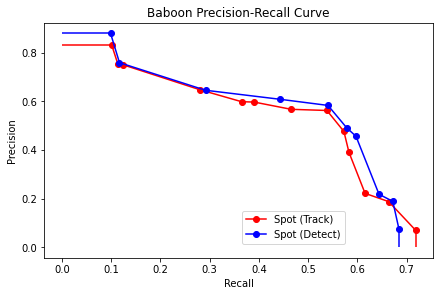

In [13]:

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), constrained_layout=True)

video_file = "Baboons/NeilThomas/001"
video_idx = VIDEO_FILES.index(video_file)

track_ypredict, _ = get_pareto_front(video_file, True, False)
track_ypredict_order = np.argsort(track_ypredict[:, 0])
track_ypredict = track_ypredict[track_ypredict_order, :]

detect_ypredict, _ = get_pareto_front(video_file, False, False)
detect_ypredict_order = np.argsort(detect_ypredict[:, 0])
detect_ypredict = detect_ypredict[detect_ypredict_order, :]

axs.plot(
    track_ypredict[:, 0],
    track_ypredict[:, 1],
    c="red",
    marker="o",
    label="Spot (Track)",
)
axs.hlines(y=track_ypredict[0, 1], xmin=0, xmax=track_ypredict[0, 0], color='red')
axs.vlines(x=track_ypredict[-1, 0], ymin=0, ymax=track_ypredict[-1, 1], color='red')

axs.plot(
    detect_ypredict[:, 0],
    detect_ypredict[:, 1],
    c="blue",
    marker="o",
    label="Spot (Detect)",
)
axs.hlines(y=detect_ypredict[0, 1], xmin=0, xmax=detect_ypredict[0, 0], color='blue')
axs.vlines(x=detect_ypredict[-1, 0], ymin=0, ymax=detect_ypredict[-1, 1], color='blue')

axs.set_title(f"Baboon Precision-Recall Curve")
axs.set(xlabel="Recall", ylabel="Precision")
    
handles, labels = axs.get_legend_handles_labels()
fig.legend(
    handles, labels, loc="lower right", bbox_to_anchor=(0.8, 0.15)
)
plt.savefig("./output/figures/fig_baboons_pr_curve.pdf", format="pdf")

In [14]:
track_areas = []
detect_areas = []

for i, video_file in enumerate(VIDEO_FILES):
    track_ypredict, _ = get_pareto_front(video_file, True, False)
    track_ypredict_order = np.argsort(track_ypredict[:, 0])
    track_ypredict = track_ypredict[track_ypredict_order, :]

    detect_ypredict, _ = get_pareto_front(video_file, False, False)
    detect_ypredict_order = np.argsort(detect_ypredict[:, 0])
    detect_ypredict = detect_ypredict[detect_ypredict_order, :]

    track_area = np.trapz(track_ypredict[:, 1], x=track_ypredict[:, 0])
    detect_area = np.trapz(detect_ypredict[:, 1], x=detect_ypredict[:, 0])

    track_area += track_ypredict[0, 0] * track_ypredict[0, 1]
    detect_area += detect_ypredict[0, 0] * detect_ypredict[0, 1]

    track_areas.append(track_area)
    detect_areas.append(detect_area)

    print(f"Track: {track_area:.2}, Detect {detect_area:.2}")

avg_track_area = np.average(track_areas)
avg_detect_area = np.average(detect_areas)

print(f"Avg Track: {avg_track_area: .2}, Avg Detect: {avg_detect_area: .2}")

Track: 0.41, Detect 0.43
Avg Track:  0.41, Avg Detect:  0.43
